In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [23]:
%autoreload 2

import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from PIL import Image
from rasterio.mask import mask

from estuary.util import false_color, normalized_image_3_channel

In [3]:
dove_labels = pd.read_csv("/Volumes/x10pro/estuary/ca_all/dove/labels.csv")
dove_labels["acquired"] = pd.to_datetime(dove_labels["acquired"], errors="coerce")
dove_labels = (
    dove_labels[dove_labels.label != "unsure"]
    .reset_index(drop=True)
    .sort_values(["region", "acquired"])
)
ss_labels = pd.read_csv("/Volumes/x10pro/estuary/skysat/labels.csv")
ss_labels["acquired"] = pd.to_datetime(ss_labels["acquired"], errors="coerce")
ss_labels = (
    ss_labels[ss_labels.label != "unsure"]
    .reset_index(drop=True)
    .sort_values(["region", "acquired"])
)

tol = pd.Timedelta("14h")

# cross-join within region, then filter by window
tmp = dove_labels.merge(ss_labels, on="region", suffixes=("_dd", "_ss"))
mask = (tmp["acquired_dd"] >= tmp["acquired_ss"] - tol) & (
    tmp["acquired_dd"] <= tmp["acquired_ss"] + tol
)
pairs = tmp.loc[mask].sort_values(["region", "acquired_dd"])

pairs.head()

region                                      source_tif_dd label_dd  \
1596      21  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
1636      21  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
1656      21  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
1695      21  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
5363      21  /Volumes/x10pro/estuary/ca_all/dove/results/20...     open   

             acquired_dd instrument_dd  \
1596 2017-12-12 18:01:06          dove   
1636 2017-12-17 18:02:18          dove   
1656 2017-12-18 18:01:26          dove   
1695 2017-12-26 18:02:59          dove   
5363 2019-04-12 17:31:35          dove   

                                          source_tif_ss  \
1596  /Volumes/x10pro/estuary/skysat/results/2017/21...   
1636  /Volumes/x10pro/estuary/skysat/results/2017/21...   
1656  /Volumes/x10pro/estuary/skysat/results/2017/21...   
1695  /Volumes/x10pro/estuary/skysat/results/2017/21...   
5363  /Volumes/x10pro/estuary/skysat/results/2019/21...   

                                            source_jpeg label_ss  \
1596  /Volumes/x10pro/estuary/ca_labeling/00077/imag...   closed   
1636  /Volumes/x10pro/estuary/ca_labeling/00077/imag...   closed   
1656  /Volumes/x10pro/estuary/ca_labeling/00077/imag...   closed   
1695  /Volumes/x10pro/estuary/ca_labeling/00077/imag...   closed   
5363  /Volumes/x10pro/estuary/ca_labeling/00077/imag...     open   

             acquired_ss instrument_ss  
1596 2017-12-12 18:45:18        skysat  
1636 2017-12-17 18:37:46        skysat  
1656 2017-12-18 18:37:35        skysat  
1695 2017-12-26 18:42:32        skysat  
5363 2019-04-12 18:34:27        skysat

In [4]:
pairs.groupby("region").label_dd.count()

region
21      13
28      69
51       4
84       9
2145     6
Name: label_dd, dtype: int64

In [223]:
region_df = pairs[
    # (pairs.label_ss != pairs.label_dd)
    pairs.region == 28
][
    [
        "region",
        "source_tif_dd",
        "label_dd",
        "acquired_dd",
        "source_tif_ss",
        "label_ss",
        "acquired_ss",
    ]
].reset_index(drop=True)
region_df["time_diff"] = (region_df.acquired_dd - region_df.acquired_ss).abs()
region_df["label_match"] = region_df.label_dd == region_df.label_ss
region_df.head(10)

region                                      source_tif_dd label_dd  \
0      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
1      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...     open   
2      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...     open   
3      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...     open   
4      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   
5      28  /Volumes/x10pro/estuary/ca_all/superdove/resul...   closed   
6      28  /Volumes/x10pro/estuary/ca_all/superdove/resul...     open   
7      28  /Volumes/x10pro/estuary/ca_all/superdove/resul...     open   
8      28  /Volumes/x10pro/estuary/ca_all/superdove/resul...     open   
9      28  /Volumes/x10pro/estuary/ca_all/dove/results/20...   closed   

          acquired_dd                                      source_tif_ss  \
0 2018-11-18 17:55:01  /Volumes/x10pro/estuary/skysat/results/2018/28...   
1 2019-06-30 18:50:25  /Volumes/x10pro/estuary/skysat/results/2019/28...   
2 2019-08-24 18:15:27  /Volumes/x10pro/estuary/skysat/results/2019/28...   
3 2021-03-16 15:39:45  /Volumes/x10pro/estuary/skysat/results/2021/28...   
4 2021-04-08 18:16:06  /Volumes/x10pro/estuary/skysat/results/2021/28...   
5 2021-05-22 18:47:36  /Volumes/x10pro/estuary/skysat/results/2021/28...   
6 2021-06-10 17:56:22  /Volumes/x10pro/estuary/skysat/results/2021/28...   
7 2021-08-16 18:40:11  /Volumes/x10pro/estuary/skysat/results/2021/28...   
8 2021-09-02 18:04:47  /Volumes/x10pro/estuary/skysat/results/2021/28...   
9 2021-10-01 18:21:56  /Volumes/x10pro/estuary/skysat/results/2021/28...   

  label_ss         acquired_ss       time_diff  label_match  
0   closed 2018-11-18 18:44:29 0 days 00:49:28         True  
1     open 2019-06-30 18:45:48 0 days 00:04:37         True  
2     open 2019-08-24 21:30:15 0 days 03:14:48         True  
3     open 2021-03-16 18:35:43 0 days 02:55:58         True  
4   closed 2021-04-08 21:35:48 0 days 03:19:42         True  
5   closed 2021-05-22 19:04:40 0 days 00:17:04         True  
6     open 2021-06-10 21:36:53 0 days 03:40:31         True  
7     open 2021-08-16 19:04:30 0 days 00:24:19         True  
8     open 2021-09-02 18:25:30 0 days 00:20:43         True  
9   closed 2021-10-01 18:26:51 0 days 00:04:55         True

In [224]:
len(region_df)

69

2024-09-18 18:07:00


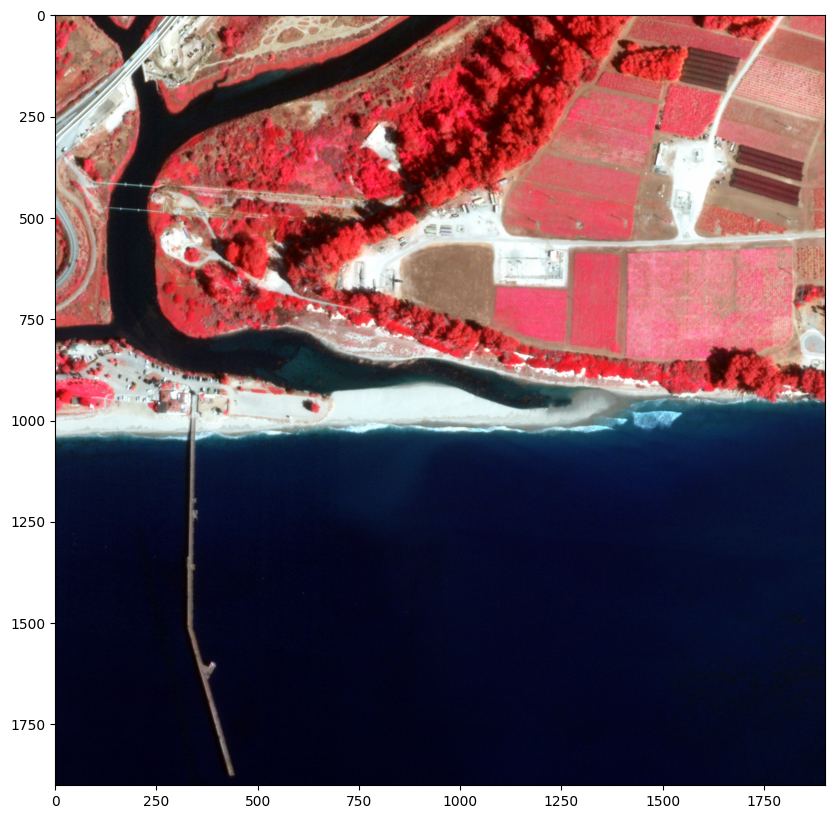

In [302]:
plt.figure(figsize=(10, 10))
row = region_df.iloc[66]
print(row.acquired_dd)
with rasterio.open(row.source_tif_ss) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
    img = Image.fromarray(img)
    # .save("/Users/kyledorman/data/estuary/display/region_53.png")
plt.imshow(img)

In [250]:
region_df[["acquired_dd", "label_dd", "label_ss"]]

acquired_dd      label_dd      label_ss
0  2018-11-18 17:55:01        closed        closed
1  2019-06-30 18:50:25          open          open
2  2019-08-24 18:15:27          open          open
3  2021-03-16 15:39:45          open          open
4  2021-04-08 18:16:06        closed        closed
..                 ...           ...           ...
64 2024-09-05 18:06:52          open          open
65 2024-09-11 18:54:44          open          open
66 2024-09-18 18:07:00  perched open  perched open
67 2024-10-30 18:53:30        closed        closed
68 2025-02-01 18:18:26          open          open

[69 rows x 3 columns]

In [176]:
to_eval = [
    (21, datetime.datetime(year=2017, month=12, day=18)),
    (21, datetime.datetime(year=2019, month=4, day=12)),
    (21, datetime.datetime(year=2021, month=5, day=3)),
    (28, datetime.datetime(year=2023, month=11, day=12)),
]

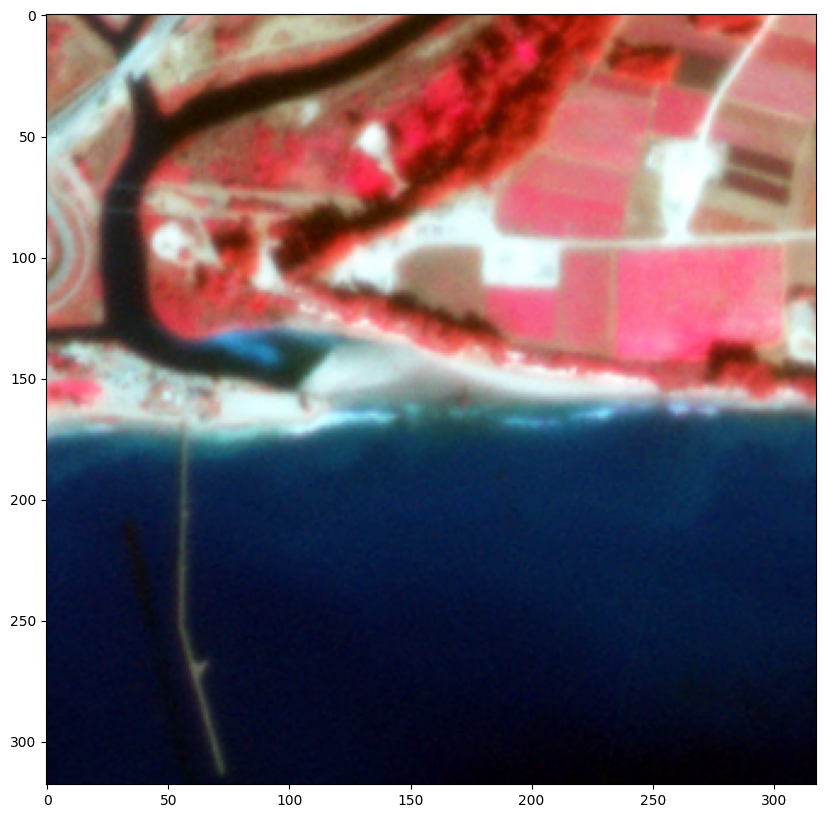

In [261]:
def dove_from_date(region, date):
    base = Path("/Volumes/x10pro/estuary/ca_all/")
    pth = list(
        base.glob(
            f"*ove/results/{date.year}/{date.month}/{region}/files/{date.year}{date.month:02}{date.day:02}*_SR*clip.tif"
        )
    )[0]
    with rasterio.open(pth) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = false_8_color(data, nodata)

    nir = data[3]
    g = data[1]
    num = g - nir
    denom = g + nir
    wi = num / denom.clip(1, denom.max())

    return img, wi


img, wi = dove_from_date(28, datetime.datetime(year=2023, month=10, day=22))

plt.figure(figsize=(10, 10))
plt.imshow(img)
# plt.figure()
# plt.imshow(wi)

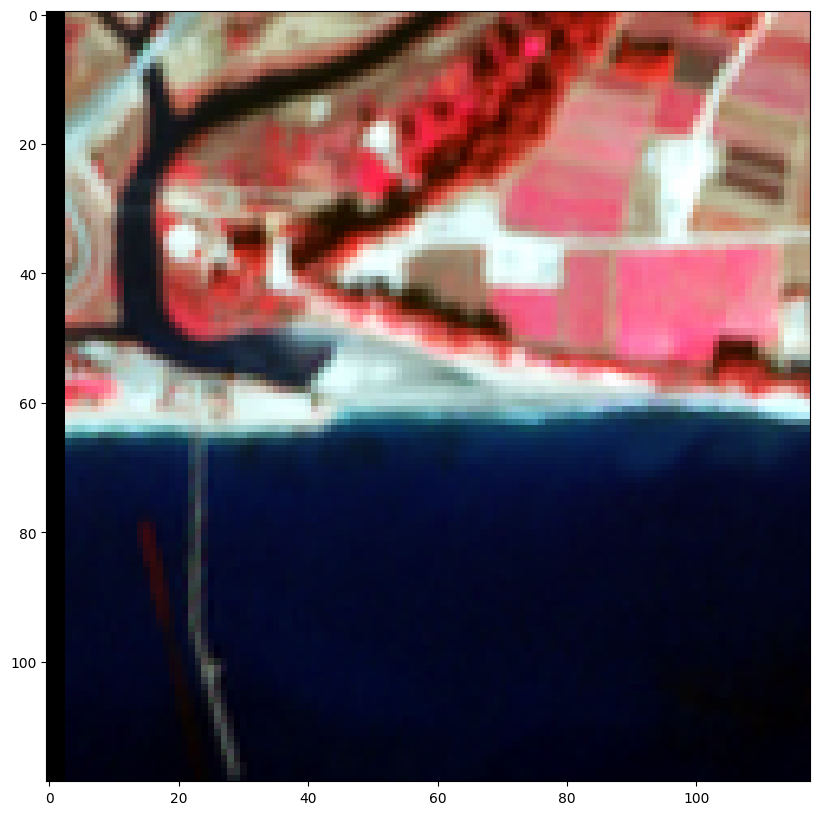

In [178]:
def false_8_color(data: np.ndarray, nodata: np.ndarray):
    img = normalized_image_3_channel(data, nodata, (7, 5, 3)).transpose((1, 2, 0))

    k = 1.5
    img = np.tanh(k * img) / np.tanh(k)

    img = np.array(img * 255, dtype=np.uint8)

    return img


def s2_false_color(bands):
    nodata = (bands == 0).all(axis=0)
    img = normalized_image_3_channel(bands, nodata, (7, 3, 2)).transpose((1, 2, 0))
    k = 1.5
    img = np.tanh(k * img) / np.tanh(k)
    img = np.array(img * 255, dtype=np.uint8)
    return img


def s2_mdwi(s2_dir):
    band_names = ["B03", "B11"]
    bands = []
    for name in band_names:
        file = list(s2_dir.glob(f"*_{name}_*"))[0]
        with rasterio.open(file) as src:
            bands.append(src.read(1, out_dtype=np.float32))

    denom = bands[0] + bands[1]
    num = bands[0] - bands[1]

    return num / denom.clip(1, denom.max())


def s2_awei_img(s2_dir):
    bands = []
    for name in S2_BAND_NAMES:
        file = list(s2_dir.glob(f"*_{name}_*"))[0]
        with rasterio.open(file) as src:
            bands.append(src.read(1, out_dtype=np.float32))

    green = bands[2]
    NIR = bands[7]
    SWIR = bands[10]
    MIR = bands[11]
    AWEI = (4 * (green - MIR)) - (0.25 * NIR - 2.75 * SWIR)
    return AWEI
    # return contrast_stretch(np.log10(1 + AWEI - AWEI.min()))


S2_BAND_NAMES = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B11",
    "B12",
]


def s2_img(s2_dir):
    bands = []
    for name in S2_BAND_NAMES:
        file = list(s2_dir.glob(f"*_{name}_*"))[0]
        with rasterio.open(file) as src:
            bands.append(src.read(1, out_dtype=np.float32))

    return s2_false_color(np.array(bands))


def s2_img_from_date(date):
    pth = Path(
        f"/Volumes/x10pro/estuary/sat_compare/sentinel/s2-{date.month:02}-{date.day:02}-{date.year}/"
    )
    img = s2_img(pth)
    wi = s2_mdwi(pth)
    return img, wi


img, wi = s2_img_from_date(to_eval[-1][1])
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [179]:
def skysat_from_date(region, date):
    base = Path(f"/Volumes/x10pro/estuary/skysat/results/{date.year}/{region}/files/")
    pth = list(base.glob(f"{date.year}{date.month:02}{date.day:02}*_pansharpened_clip.tif"))[0]
    with rasterio.open(pth) as src:
        data = src.read()
        nodata = src.read(1, masked=True).mask
        img = false_color(data, nodata)

    nir = data[3]
    g = data[1]
    num = g - nir
    denom = g + nir
    wi = num / denom.clip(1, denom.max())

    return img, wi

In [180]:
def plot_sats(region, date, save_path=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    s2i, s2w = s2_img_from_date(date)
    dovei, dovew = dove_from_date(region, date)
    ssi, ssw = skysat_from_date(region, date)

    axes[0].axis("off")
    axes[0].imshow(ssi)
    axes[0].set_title("SkySat (0.5m)")

    axes[1].axis("off")
    axes[1].imshow(dovei)
    axes[1].set_title("Dove (3m)")

    axes[2].axis("off")
    axes[2].imshow(s2i)
    axes[2].set_title("Sentinel 2 (10m)")

    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

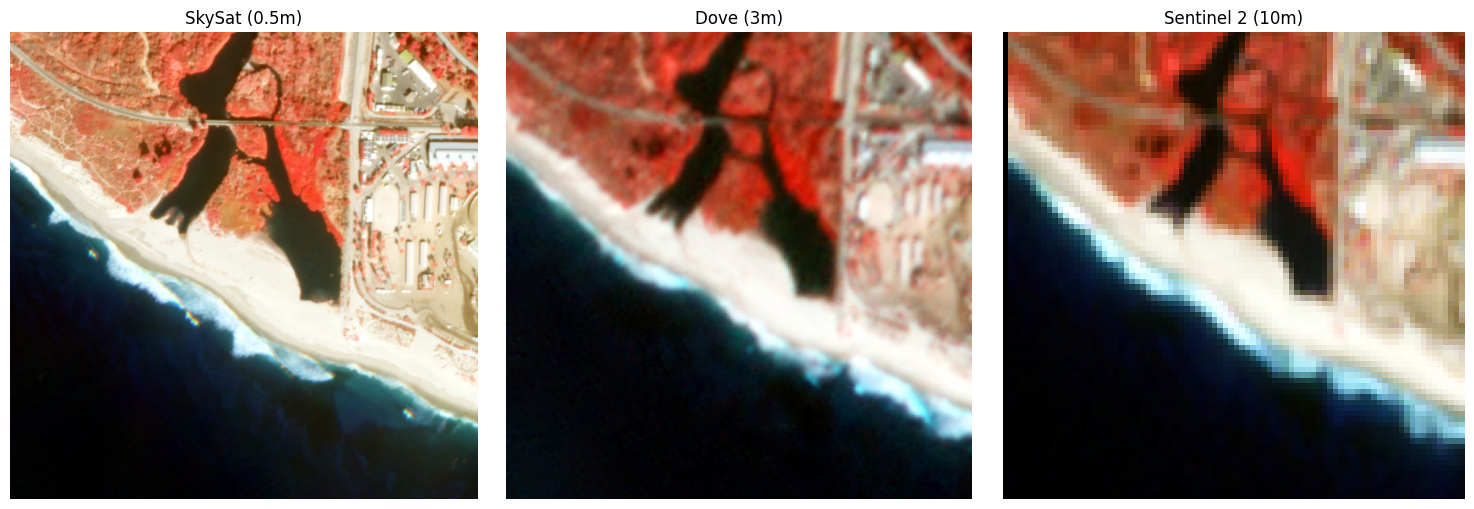

In [181]:
plot_sats(*to_eval[0])

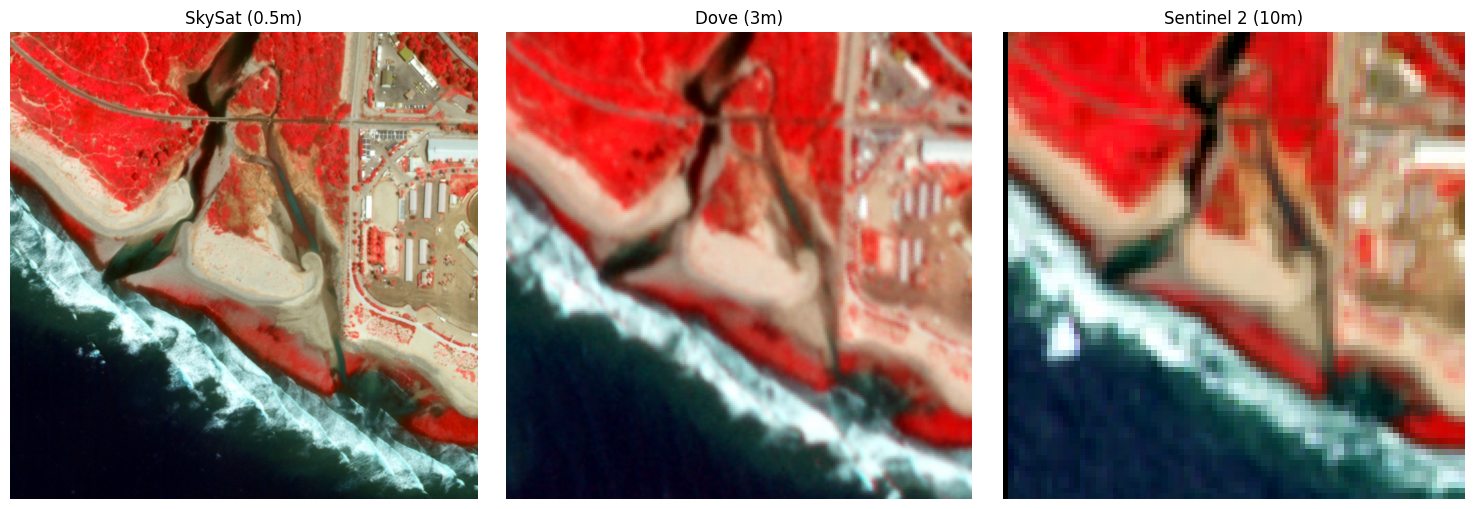

In [182]:
plot_sats(*to_eval[1])

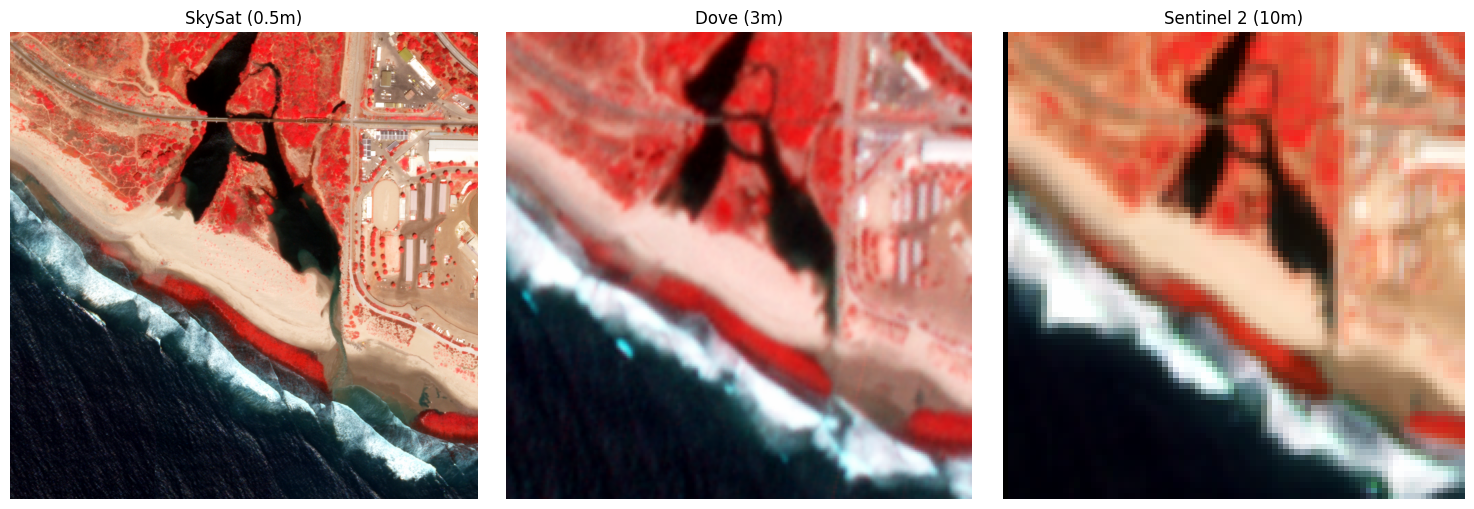

In [183]:
plot_sats(*to_eval[2])

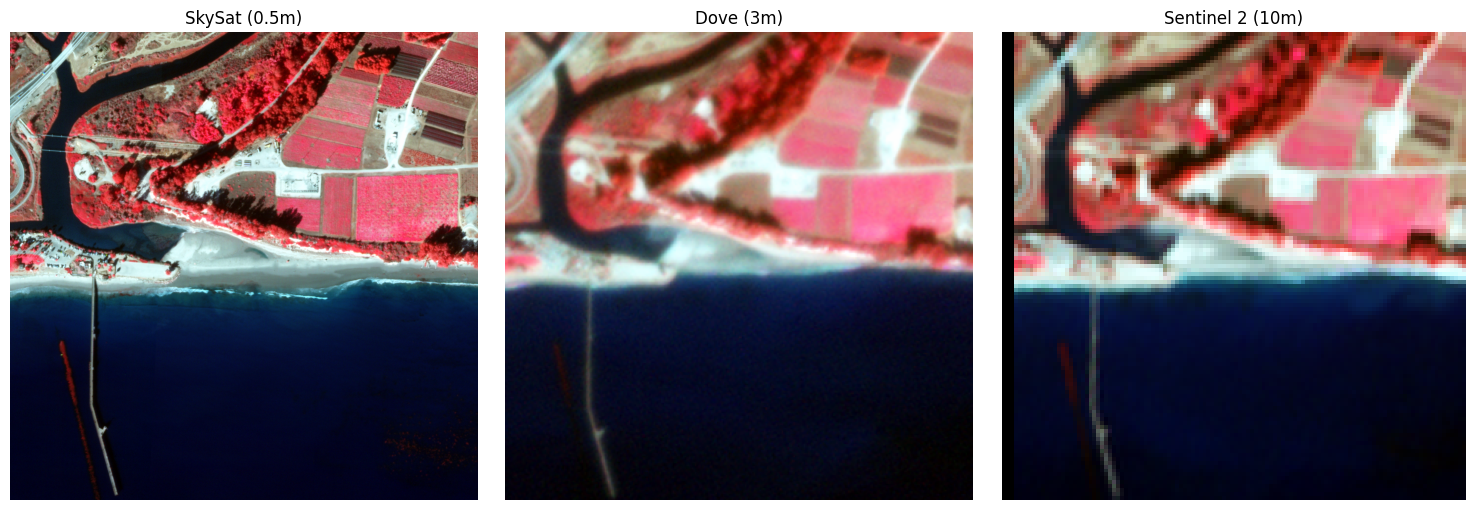

In [184]:
plot_sats(*to_eval[3])